In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install -U imbalanced-learn


# Following is the summary of the approach taken:

- Required data and libraries were imported.
- There were some inconsistencies found in date column which were cleaned prior to the analysis.
- A few columns were found with large number of missing values.
- For recharge columns with minimum value as 1, we imputed the data with 0.
- Incase of date columns with nan, we extracted the days and imputed nans with 0, since the date columns were already segregated by month.
- Incase of night pack and fb users, we imputed the nans with a new category as -1, corresponding to no information.
- We dropped the columns consisting of information of no value. For instance columns with a single value or with no significant information.
- Filtered out the high value customers.
- Created the churn flag.
- Dropped columns corresponding to the 9th month and mobile numbers.
- Split the data into train and test.
- Fit MICE imputer on train data and transformed the test data accordingly to avoid information leakage.
- Checked for outliers in the data and capped values for columns with outliers more than 10%.
- Created some flag features correspinding to columns of interest.
- Created some difference and negative difference flag features for good and action phases and within the good phase.
- Applied yeo johnson transformation for numerical features that were not normally distributed.
- Scaled the data using standard scalar.
- Applied SMOTE to deal with class imbalance.
- Applied PCA on the features and only considered PCA features that amounted for 99% information.
- Applied RandomForest, Logistic Regression and KNearest neighbours with grid search to get 3 different models.
- For interpretable model, Random Forest model was created without applying PCA on data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, classification_report,\
 accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix,\
  precision_recall_curve, roc_curve, f1_score
import time
sns.set_style('darkgrid')
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from scipy.stats import shapiro, boxcox
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Telecom Churn/telecom_churn_data.csv')


In [ ]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.0,0.0,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,0.00,0.00,38.49,0.0,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,54.86,44.38,0.00,0.0,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [ ]:
df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [ ]:
df.shape

(99999, 226)

## Cleaning date columns

In [ ]:
def date_cleaner(x):
    if pd.isnull(x):
        return x
    else:
        if '-' in str(x):
            date_list = x.split('-')
            date = '/'.join(date_list)
            return date
        else:
            return str(x)

In [ ]:
df.columns[df.columns.str.contains('date')]

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')

In [ ]:
for col in df.columns[df.columns.str.contains('date')]:
    df[col] = df[col].apply(date_cleaner)
    df[col] = pd.to_datetime(df[col], format = '%m/%d/%Y')

In [ ]:
df[df.columns[df.columns.str.contains('date')]].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-21,2014-07-16,2014-08-08,2014-09-28,2014-06-21,2014-07-16,2014-08-08,NaT
1,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-29,2014-07-31,2014-08-28,2014-09-30,NaT,2014-07-25,2014-08-10,NaT
2,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-17,2014-07-24,2014-08-14,2014-09-29,NaT,NaT,NaT,2014-09-17
3,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-28,2014-07-31,2014-08-31,2014-09-30,NaT,NaT,NaT,NaT
4,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-26,2014-07-28,2014-08-09,2014-09-28,2014-06-04,NaT,NaT,NaT


In [ ]:
df[df.columns[df.columns.str.contains('date')]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   last_date_of_month_6      99999 non-null  datetime64[ns]
 1   last_date_of_month_7      99398 non-null  datetime64[ns]
 2   last_date_of_month_8      98899 non-null  datetime64[ns]
 3   last_date_of_month_9      98340 non-null  datetime64[ns]
 4   date_of_last_rech_6       98392 non-null  datetime64[ns]
 5   date_of_last_rech_7       98232 non-null  datetime64[ns]
 6   date_of_last_rech_8       96377 non-null  datetime64[ns]
 7   date_of_last_rech_9       95239 non-null  datetime64[ns]
 8   date_of_last_rech_data_6  25153 non-null  datetime64[ns]
 9   date_of_last_rech_data_7  25571 non-null  datetime64[ns]
 10  date_of_last_rech_data_8  26339 non-null  datetime64[ns]
 11  date_of_last_rech_data_9  25922 non-null  datetime64[ns]
dtypes: datetime64[ns](

### Checking nulls

In [ ]:
check_null_df = df.isnull().sum().to_frame().rename(columns = {0:'counts'})
check_null_df['counts'] = check_null_df['counts']/len(df)
nulls_more_than_50 = check_null_df[(check_null_df['counts']>0.5)].sort_values('counts', ascending = False)
nulls_more_than_50

,counts
date_of_last_rech_data_6,0.748467
max_rech_data_6,0.748467
fb_user_6,0.748467
night_pck_user_6,0.748467
arpu_2g_6,0.748467
arpu_3g_6,0.748467
count_rech_3g_6,0.748467
count_rech_2g_6,0.748467
av_rech_amt_data_6,0.748467
total_rech_data_6,0.748467


## Analysing recharge columns

In [ ]:
rech_cols_summary = df[df.columns[df.columns.str.contains('rech')]].describe().T
rech_cols_summary

,count,mean,std,min,25%,50%,75%,max
total_rech_num_6,99999.0,7.558806,7.078405,0.0,3.0,6.0,9.0,307.0
total_rech_num_7,99999.0,7.700367,7.070422,0.0,3.0,6.0,10.0,138.0
total_rech_num_8,99999.0,7.212912,7.203753,0.0,3.0,5.0,9.0,196.0
total_rech_num_9,99999.0,6.893019,7.096261,0.0,3.0,5.0,9.0,131.0
total_rech_amt_6,99999.0,327.514615,398.019701,0.0,109.0,230.0,437.5,35190.0
total_rech_amt_7,99999.0,322.962970,408.114237,0.0,100.0,220.0,428.0,40335.0
total_rech_amt_8,99999.0,324.157122,416.540455,0.0,90.0,225.0,434.5,45320.0
total_rech_amt_9,99999.0,303.345673,404.588583,0.0,52.0,200.0,415.0,37235.0
max_rech_amt_6,99999.0,104.637486,120.614894,0.0,30.0,110.0,120.0,4010.0
max_rech_amt_7,99999.0,104.752398,124.523970,0.0,30.0,110.0,128.0,4010.0


### Imputing columns with Nans and min as 1 with 0

In [ ]:
for col in rech_cols_summary[rech_cols_summary['min']==1].index:
  df[col] = df[col].fillna(0)

In [ ]:
check_null_df = df.isnull().sum().to_frame().rename(columns = {0:'counts'})
check_null_df['counts'] = check_null_df['counts']/len(df)
nulls_more_than_50 = check_null_df[(check_null_df['counts']>0.5)].sort_values('counts', ascending = False)
nulls_more_than_50

,counts
date_of_last_rech_data_6,0.748467
fb_user_6,0.748467
count_rech_2g_6,0.748467
night_pck_user_6,0.748467
count_rech_3g_6,0.748467
arpu_2g_6,0.748467
arpu_3g_6,0.748467
av_rech_amt_data_7,0.744287
fb_user_7,0.744287
night_pck_user_7,0.744287


In [ ]:
df['date_of_last_rech_data_6'].unique()

array(['2014-06-21T00:00:00.000000000',                           'NaT',
       '2014-06-04T00:00:00.000000000', '2014-06-27T00:00:00.000000000',
       '2014-06-30T00:00:00.000000000', '2014-06-06T00:00:00.000000000',
       '2014-06-02T00:00:00.000000000', '2014-06-12T00:00:00.000000000',
       '2014-06-19T00:00:00.000000000', '2014-06-29T00:00:00.000000000',
       '2014-06-05T00:00:00.000000000', '2014-06-17T00:00:00.000000000',
       '2014-06-11T00:00:00.000000000', '2014-06-25T00:00:00.000000000',
       '2014-06-10T00:00:00.000000000', '2014-06-20T00:00:00.000000000',
       '2014-06-23T00:00:00.000000000', '2014-06-13T00:00:00.000000000',
       '2014-06-26T00:00:00.000000000', '2014-06-16T00:00:00.000000000',
       '2014-06-14T00:00:00.000000000', '2014-06-24T00:00:00.000000000',
       '2014-06-28T00:00:00.000000000', '2014-06-15T00:00:00.000000000',
       '2014-06-09T00:00:00.000000000', '2014-06-22T00:00:00.000000000',
       '2014-06-01T00:00:00.000000000', '2014-06-08

In [ ]:
df['date_of_last_rech_data_7'].unique()

array(['2014-07-16T00:00:00.000000000', '2014-07-25T00:00:00.000000000',
                                 'NaT', '2014-07-31T00:00:00.000000000',
       '2014-07-23T00:00:00.000000000', '2014-07-07T00:00:00.000000000',
       '2014-07-27T00:00:00.000000000', '2014-07-02T00:00:00.000000000',
       '2014-07-28T00:00:00.000000000', '2014-07-12T00:00:00.000000000',
       '2014-07-04T00:00:00.000000000', '2014-07-05T00:00:00.000000000',
       '2014-07-06T00:00:00.000000000', '2014-07-26T00:00:00.000000000',
       '2014-07-19T00:00:00.000000000', '2014-07-10T00:00:00.000000000',
       '2014-07-11T00:00:00.000000000', '2014-07-29T00:00:00.000000000',
       '2014-07-18T00:00:00.000000000', '2014-07-09T00:00:00.000000000',
       '2014-07-24T00:00:00.000000000', '2014-07-14T00:00:00.000000000',
       '2014-07-13T00:00:00.000000000', '2014-07-22T00:00:00.000000000',
       '2014-07-30T00:00:00.000000000', '2014-07-20T00:00:00.000000000',
       '2014-07-21T00:00:00.000000000', '2014-07-15

In [ ]:
df['date_of_last_rech_data_8'].unique()

array(['2014-08-08T00:00:00.000000000', '2014-08-10T00:00:00.000000000',
                                 'NaT', '2014-08-23T00:00:00.000000000',
       '2014-08-24T00:00:00.000000000', '2014-08-21T00:00:00.000000000',
       '2014-08-30T00:00:00.000000000', '2014-08-06T00:00:00.000000000',
       '2014-08-25T00:00:00.000000000', '2014-08-07T00:00:00.000000000',
       '2014-08-26T00:00:00.000000000', '2014-08-11T00:00:00.000000000',
       '2014-08-02T00:00:00.000000000', '2014-08-31T00:00:00.000000000',
       '2014-08-20T00:00:00.000000000', '2014-08-29T00:00:00.000000000',
       '2014-08-17T00:00:00.000000000', '2014-08-14T00:00:00.000000000',
       '2014-08-28T00:00:00.000000000', '2014-08-03T00:00:00.000000000',
       '2014-08-15T00:00:00.000000000', '2014-08-18T00:00:00.000000000',
       '2014-08-19T00:00:00.000000000', '2014-08-27T00:00:00.000000000',
       '2014-08-13T00:00:00.000000000', '2014-08-22T00:00:00.000000000',
       '2014-08-01T00:00:00.000000000', '2014-08-09

### Extracting only the day of the month and imputing the day as 0 if the value was NaN

In [ ]:
for col in ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']:
  df[col] = df[col].dt.day
  df[col] = df[col].fillna(0)

In [ ]:
df[df.columns[df.columns.str.contains('user')]].describe().T

,count,mean,std,min,25%,50%,75%,max
night_pck_user_6,25153.0,0.025086,0.156391,0.0,0.0,0.0,0.0,1.0
night_pck_user_7,25571.0,0.023034,0.150014,0.0,0.0,0.0,0.0,1.0
night_pck_user_8,26339.0,0.020844,0.142863,0.0,0.0,0.0,0.0,1.0
night_pck_user_9,25922.0,0.015971,0.125366,0.0,0.0,0.0,0.0,1.0
fb_user_6,25153.0,0.914404,0.279772,0.0,1.0,1.0,1.0,1.0
fb_user_7,25571.0,0.908764,0.287950,0.0,1.0,1.0,1.0,1.0
fb_user_8,26339.0,0.890808,0.311885,0.0,1.0,1.0,1.0,1.0
fb_user_9,25922.0,0.860968,0.345987,0.0,1.0,1.0,1.0,1.0


In [ ]:
df[df.columns[df.columns.str.contains('night')]].describe().T

,count,mean,std,min,25%,50%,75%,max
night_pck_user_6,25153.0,0.025086,0.156391,0.0,0.0,0.0,0.0,1.0
night_pck_user_7,25571.0,0.023034,0.150014,0.0,0.0,0.0,0.0,1.0
night_pck_user_8,26339.0,0.020844,0.142863,0.0,0.0,0.0,0.0,1.0
night_pck_user_9,25922.0,0.015971,0.125366,0.0,0.0,0.0,0.0,1.0


### Imputing night pack user columns with -1

In [ ]:

for col in df.columns[df.columns.str.contains('night')].to_list():
  df[col].fillna(-1, inplace=True)


In [ ]:
cond = ((df['night_pck_user_6']==1) | (df['night_pck_user_7']==1)) & ((df['night_pck_user_8']==0) | (df['night_pck_user_8']==-1))
df['night_pck_user_diff'] = np.where(cond, 1, 0)

## Analysing FB user

In [ ]:
df[df.columns[df.columns.str.contains('user')]].isnull().sum()

night_pck_user_6           0
night_pck_user_7           0
night_pck_user_8           0
night_pck_user_9           0
fb_user_6              74846
fb_user_7              74428
fb_user_8              73660
fb_user_9              74077
night_pck_user_diff        0
dtype: int64

### Imputing NaNs in fb users with -1

In [ ]:
for col in df.columns[df.columns.str.contains('fb_user')].to_list():
  df[col].fillna(-1, inplace=True)

In [ ]:
cond = ((df['fb_user_6']==1) | (df['fb_user_7']==1)) & ((df['fb_user_8']==0) | (df['fb_user_8']==-1))
df['fb_user_diff'] = np.where(cond, 1, 0)

In [ ]:
check_null_df = df.isnull().sum().to_frame().rename(columns = {0:'counts'})
check_null_df['counts'] = check_null_df['counts']/len(df)
nulls_more_than_50 = check_null_df[(check_null_df['counts']>0.5)].sort_values('counts', ascending = False)
nulls_more_than_50

,counts
arpu_3g_6,0.748467
arpu_2g_6,0.748467
count_rech_3g_6,0.748467
count_rech_2g_6,0.748467
av_rech_amt_data_7,0.744287
count_rech_2g_7,0.744287
arpu_2g_7,0.744287
count_rech_3g_7,0.744287
arpu_3g_7,0.744287
arpu_3g_9,0.740777


In [ ]:
df[nulls_more_than_50.index].describe()

,arpu_3g_6,arpu_2g_6,count_rech_3g_6,count_rech_2g_6,av_rech_amt_data_7,count_rech_2g_7,arpu_2g_7,count_rech_3g_7,arpu_3g_7,arpu_3g_9,count_rech_3g_9,count_rech_2g_9,arpu_2g_9,av_rech_amt_data_8,arpu_3g_8,count_rech_3g_8,count_rech_2g_8,arpu_2g_8
count,25153.000000,25153.000000,25153.000000,25153.000000,25571.000000,25571.000000,25571.000000,25571.000000,25571.000000,25922.000000,25922.000000,25922.000000,25922.000000,26339.000000,26339.000000,26339.000000,26339.000000,26339.000000
mean,89.555057,86.398003,0.599133,1.864668,200.981292,2.044699,85.914450,0.621720,89.384120,100.264116,0.659363,1.781807,93.712026,197.526489,91.173849,0.635711,2.016288,86.599478
std,193.124653,172.767523,1.274428,2.570254,196.791224,2.768332,176.379871,1.394524,195.893924,216.291992,1.411513,2.214701,171.384224,191.301305,188.180936,1.422827,2.720132,168.247852
min,-30.820000,-35.830000,0.000000,0.000000,0.500000,0.000000,-15.480000,0.000000,-26.040000,-71.090000,0.000000,0.000000,-45.740000,0.500000,-24.490000,0.000000,0.000000,-55.830000
25%,0.000000,0.000000,0.000000,1.000000,92.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,87.000000,0.000000,0.000000,1.000000,0.000000
50%,0.480000,10.830000,0.000000,1.000000,154.000000,1.000000,8.810000,0.000000,0.420000,2.605000,0.000000,1.000000,14.800000,154.000000,0.880000,0.000000,1.000000,9.270000
75%,122.070000,122.070000,1.000000,2.000000,252.000000,2.000000,122.070000,1.000000,119.560000,140.010000,1.000000,2.000000,140.010000,252.000000,122.070000,1.000000,2.000000,122.070000
max,6362.280000,6433.760000,29.000000,42.000000,4365.000000,48.000000,4809.360000,35.000000,4980.900000,13884.310000,49.000000,40.000000,3467.170000,4076.000000,3716.900000,45.000000,44.000000,3483.170000


### Dropping columns with large number of null values

In [ ]:
df.drop(nulls_more_than_50.index, axis = 1, inplace = True)

### Checking the remaining nulls

In [ ]:
check_null_df = df.isnull().sum().to_frame().rename(columns = {0:'counts'})
check_null_df[check_null_df['counts']!=0].sort_values(by = 'counts', ascending = False)/len(df)

,counts
loc_og_t2f_mou_9,0.077451
loc_og_t2t_mou_9,0.077451
std_ic_t2o_mou_9,0.077451
loc_og_mou_9,0.077451
roam_og_mou_9,0.077451
...,...
last_date_of_month_8,0.011000
std_og_t2o_mou,0.010180
loc_ic_t2o_mou,0.010180
loc_og_t2o_mou,0.010180


In [ ]:
df[df.columns[df.columns.str.contains('date')]].isna().sum()

last_date_of_month_6           0
last_date_of_month_7         601
last_date_of_month_8        1100
last_date_of_month_9        1659
date_of_last_rech_6         1607
date_of_last_rech_7         1767
date_of_last_rech_8         3622
date_of_last_rech_9         4760
date_of_last_rech_data_6       0
date_of_last_rech_data_7       0
date_of_last_rech_data_8       0
dtype: int64

In [ ]:
df['last_date_of_month_7'].unique()

array(['2014-07-31T00:00:00.000000000',                           'NaT'],
      dtype='datetime64[ns]')

In [ ]:
df['last_date_of_month_6'].unique()

array(['2014-06-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
df['last_date_of_month_8'].unique()

array(['2014-08-31T00:00:00.000000000',                           'NaT'],
      dtype='datetime64[ns]')

### Dropping these columns since they contain no information.

In [ ]:
df.drop(['last_date_of_month_7', 'last_date_of_month_6', 'last_date_of_month_8'], axis = 1, inplace = True)

### Analysing these date columns further 

In [ ]:
df['date_of_last_rech_6'].unique()

array(['2014-06-21T00:00:00.000000000', '2014-06-29T00:00:00.000000000',
       '2014-06-17T00:00:00.000000000', '2014-06-28T00:00:00.000000000',
       '2014-06-26T00:00:00.000000000', '2014-06-19T00:00:00.000000000',
       '2014-06-27T00:00:00.000000000', '2014-06-25T00:00:00.000000000',
       '2014-06-14T00:00:00.000000000', '2014-06-18T00:00:00.000000000',
       '2014-06-20T00:00:00.000000000', '2014-06-30T00:00:00.000000000',
       '2014-06-23T00:00:00.000000000',                           'NaT',
       '2014-06-22T00:00:00.000000000', '2014-06-24T00:00:00.000000000',
       '2014-06-12T00:00:00.000000000', '2014-06-03T00:00:00.000000000',
       '2014-06-11T00:00:00.000000000', '2014-06-16T00:00:00.000000000',
       '2014-06-10T00:00:00.000000000', '2014-06-15T00:00:00.000000000',
       '2014-06-13T00:00:00.000000000', '2014-06-07T00:00:00.000000000',
       '2014-06-08T00:00:00.000000000', '2014-06-06T00:00:00.000000000',
       '2014-06-02T00:00:00.000000000', '2014-06-04

In [ ]:
df['date_of_last_rech_7'].unique()

array(['2014-07-16T00:00:00.000000000', '2014-07-31T00:00:00.000000000',
       '2014-07-24T00:00:00.000000000', '2014-07-28T00:00:00.000000000',
       '2014-07-17T00:00:00.000000000', '2014-07-25T00:00:00.000000000',
       '2014-07-23T00:00:00.000000000', '2014-07-05T00:00:00.000000000',
       '2014-07-10T00:00:00.000000000', '2014-07-22T00:00:00.000000000',
       '2014-07-30T00:00:00.000000000', '2014-07-03T00:00:00.000000000',
       '2014-07-07T00:00:00.000000000', '2014-07-29T00:00:00.000000000',
       '2014-07-27T00:00:00.000000000', '2014-07-19T00:00:00.000000000',
       '2014-07-14T00:00:00.000000000', '2014-07-20T00:00:00.000000000',
       '2014-07-04T00:00:00.000000000', '2014-07-12T00:00:00.000000000',
                                 'NaT', '2014-07-26T00:00:00.000000000',
       '2014-07-11T00:00:00.000000000', '2014-07-06T00:00:00.000000000',
       '2014-07-21T00:00:00.000000000', '2014-07-13T00:00:00.000000000',
       '2014-07-15T00:00:00.000000000', '2014-07-18

In [ ]:
df['date_of_last_rech_8'].unique()

array(['2014-08-08T00:00:00.000000000', '2014-08-28T00:00:00.000000000',
       '2014-08-14T00:00:00.000000000', '2014-08-31T00:00:00.000000000',
       '2014-08-09T00:00:00.000000000', '2014-08-24T00:00:00.000000000',
       '2014-08-26T00:00:00.000000000', '2014-08-30T00:00:00.000000000',
       '2014-08-29T00:00:00.000000000', '2014-08-27T00:00:00.000000000',
       '2014-08-21T00:00:00.000000000', '2014-08-10T00:00:00.000000000',
       '2014-08-25T00:00:00.000000000', '2014-08-19T00:00:00.000000000',
       '2014-08-22T00:00:00.000000000', '2014-08-02T00:00:00.000000000',
       '2014-08-13T00:00:00.000000000', '2014-08-05T00:00:00.000000000',
       '2014-08-18T00:00:00.000000000', '2014-08-20T00:00:00.000000000',
       '2014-08-23T00:00:00.000000000', '2014-08-12T00:00:00.000000000',
       '2014-08-11T00:00:00.000000000', '2014-08-16T00:00:00.000000000',
       '2014-08-15T00:00:00.000000000', '2014-08-06T00:00:00.000000000',
                                 'NaT', '2014-08-17

### Imputing these columns with mode

In [ ]:
df['date_of_last_rech_6'] = np.where(df['date_of_last_rech_6'].isnull(), df['date_of_last_rech_6'].mode(), df['date_of_last_rech_6'])
df['date_of_last_rech_7'] = np.where(df['date_of_last_rech_7'].isnull(), df['date_of_last_rech_7'].mode(), df['date_of_last_rech_7'])
df['date_of_last_rech_8'] = np.where(df['date_of_last_rech_8'].isnull(), df['date_of_last_rech_8'].mode(), df['date_of_last_rech_8'])

In [ ]:
df.columns[df.columns.str.contains('date')]

Index(['last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

## Encoding Date columns with day of the month

In [ ]:
df['date_of_last_rech_6'] = df['date_of_last_rech_6'].dt.day
df['date_of_last_rech_7'] = df['date_of_last_rech_7'].dt.day
df['date_of_last_rech_8'] = df['date_of_last_rech_8'].dt.day

## Checking columns for single unique values to eliminate

In [ ]:
for col in df.columns:
    if len(df[col].unique())<=2:
        print(col)

circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9
night_pck_user_diff
fb_user_diff


In [ ]:
df['circle_id'].unique()

array([109])

In [ ]:
df['loc_og_t2o_mou'].unique()

array([ 0., nan])

In [ ]:
df['std_og_t2o_mou'].unique()

array([ 0., nan])

In [ ]:
df['loc_ic_t2o_mou'].unique()

array([ 0., nan])

In [ ]:
df['std_og_t2c_mou_6'].unique()

array([nan,  0.])

In [ ]:
df['std_og_t2c_mou_7'].unique()

array([nan,  0.])

In [ ]:
df['std_og_t2c_mou_8'].unique()

array([ 0., nan])

In [ ]:
df['std_ic_t2o_mou_6'].unique()

array([nan,  0.])

In [ ]:
df['std_ic_t2o_mou_7'].unique()

array([nan,  0.])

In [ ]:
df['std_ic_t2o_mou_8'].unique()

array([ 0., nan])

### Dropping the above columns since they dont have any values of significance

In [ ]:
to_drop = [col for col in df.columns if len(df[col].unique())<=2]
df.drop(to_drop, axis = 1, inplace = True)

In [ ]:
df.shape

(99999, 191)

In [ ]:
check_null_df = df.isnull().sum().to_frame().rename(columns = {0:'counts'})/len(df)
check_null_df[check_null_df['counts']!=0].sort_values(by = 'counts', ascending = False)

,counts
loc_og_t2f_mou_9,0.077451
std_ic_mou_9,0.077451
loc_ic_mou_9,0.077451
loc_og_t2c_mou_9,0.077451
std_og_t2t_mou_9,0.077451
...,...
loc_og_mou_7,0.038590
std_ic_t2t_mou_7,0.038590
std_ic_t2m_mou_7,0.038590
loc_og_t2f_mou_7,0.038590


### Dropping sep_vbc_3g as it corresponds to 9th month data and mobile number as it is the key.

In [ ]:
df.drop(['mobile_number', 'sep_vbc_3g'], axis = 1, inplace = True)

## Filtering high value customers

In [ ]:
df[df.columns[df.columns.str.contains('rech')]].columns

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_9'],
      dtype='object')

In [ ]:
df['avg_total_rech_amount'] = (df['total_rech_amt_6'].fillna(0) + df['total_rech_amt_7'].fillna(0))/2

In [ ]:
df = df[df['avg_total_rech_amount'] >=  df['avg_total_rech_amount'].quantile(0.7)].copy()

In [ ]:
df.shape

(30011, 190)

## Creating churn flag

In [ ]:
df['total_ic_mou_9'].isnull().sum()

0

In [ ]:
df['total_og_mou_9'].isnull().sum()

0

In [ ]:
df['vol_2g_mb_9'].isnull().sum()

0

In [ ]:
df['vol_3g_mb_9'].isnull().sum()

0

In [ ]:
churn_cond = (df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0)

In [ ]:
df['churn_flag'] = np.where(churn_cond, 1, 0)

In [ ]:
df['churn_flag'].value_counts(normalize=True).to_frame()

,churn_flag
0,0.913598
1,0.086402


## Dropping columns related to churn period

In [ ]:
df.drop(df.columns[df.columns.str.contains('_9')], axis = 1, inplace = True)

In [ ]:
df['churn_flag'].value_counts(normalize = True)

0    0.913598
1    0.086402
Name: churn_flag, dtype: float64

In [ ]:
y = df['churn_flag']
X = df.drop('churn_flag', axis = 1)

### Applying stratified sampling at the time of split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)

### Applying MICE imputation

In [ ]:
lin_reg = LinearRegression(n_jobs = -1)

imp = IterativeImputer(estimator = lin_reg, verbose = 3, max_iter = 15)
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns = X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns = X_test.columns, index=X_test.index)


[IterativeImputer] Completing matrix with shape (21007, 144)
[IterativeImputer] Ending imputation round 1/15, elapsed time 33.76
[IterativeImputer] Change: 653232.6610635301, scaled tolerance: 45.735400000000006 
[IterativeImputer] Ending imputation round 2/15, elapsed time 67.76
[IterativeImputer] Change: 249919.55921119952, scaled tolerance: 45.735400000000006 
[IterativeImputer] Ending imputation round 3/15, elapsed time 101.25
[IterativeImputer] Change: 440533.60430080775, scaled tolerance: 45.735400000000006 
[IterativeImputer] Ending imputation round 4/15, elapsed time 135.25
[IterativeImputer] Change: 99048.94561244846, scaled tolerance: 45.735400000000006 
[IterativeImputer] Ending imputation round 5/15, elapsed time 167.88
[IterativeImputer] Change: 17279.03750789352, scaled tolerance: 45.735400000000006 
[IterativeImputer] Ending imputation round 6/15, elapsed time 201.36
[IterativeImputer] Change: 2880.401884528939, scaled tolerance: 45.735400000000006 
[IterativeImputer] En

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Ending imputation round 1/15, elapsed time 0.14
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.27
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.40
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.52
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.65
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.79
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.92
[IterativeImputer] Ending imputation round 8/15, elapsed time 1.04
[IterativeImputer] Ending imputation round 9/15, elapsed time 1.17
[IterativeImputer] Ending imputation round 10/15, elapsed time 1.30
[IterativeImputer] Ending imputation round 11/15, elapsed time 1.43
[IterativeImputer] Ending imputation round 12/15, elapsed time 1.55
[IterativeImputer] Ending imputation round 13/15, elapsed time 1.68
[IterativeImputer] Ending imputation round 14/15, elapsed time 1.81
[IterativeImputer] Ending imputation round 15/15, elapsed

In [ ]:
X_train_imp.shape

(21007, 144)

In [ ]:
outlier_count = []
for col in X_train_imp.columns:
  q1 = X_train_imp[col].quantile(0.25)
  q3 = X_train_imp[col].quantile(0.75)
  med = X_train_imp[col].median()
  IQR = q3-q1
  outlier_cond = (X_train_imp[col] >  med + 1.5*IQR) | (X_train_imp[col] <  med - 1.5*IQR)
  outlier_count.append(len(X_train_imp[outlier_cond])/len(X_train_imp))
outlier_df = pd.DataFrame({'columns':X_train_imp.columns, 'outlier_count':outlier_count})
outlier_df

,columns,outlier_count
0,arpu_6,0.096111
1,arpu_7,0.101538
2,arpu_8,0.089399
3,onnet_mou_6,0.151664
4,onnet_mou_7,0.153044
...,...,...
139,aon,0.069025
140,aug_vbc_3g,0.249250
141,jul_vbc_3g,0.249631
142,jun_vbc_3g,0.237349


In [ ]:
outlier_df.describe()

,outlier_count
count,144.000000
mean,0.148377
std,0.063501
min,0.000000
25%,0.106143
50%,0.145047
75%,0.199517
max,0.249631


In [ ]:
train_imp = pd.concat([X_train_imp, y_train], axis = 1)

### Checking Outliers

In [ ]:
for col in outlier_df[outlier_df['outlier_count'] <= 0.1]['columns']:
  q1 = train_imp[col].quantile(0.25)
  q3 = train_imp[col].quantile(0.75)
  med = train_imp[col].median()
  IQR = q3-q1
  #outlier_cond = (train_imp[col] >  med + 2.5*IQR) | (train_imp[col] <  med - 2.5*IQR)
  #train_imp = train_imp[~outlier_cond].copy()
  train_imp[col] = np.where(train_imp[col] >  med + 1.5*IQR, med + 1.5*IQR, train_imp[col])
  train_imp[col] = np.where(train_imp[col] <  med - 1.5*IQR, med - 1.5*IQR, train_imp[col])

In [ ]:
train_imp.churn_flag.value_counts(normalize = True)

0    0.9136
1    0.0864
Name: churn_flag, dtype: float64

### Treating aon

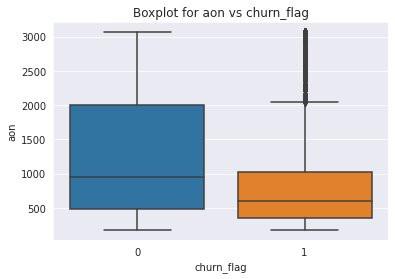

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'aon').set_title('Boxplot for aon vs churn_flag')
plt.show()

In [ ]:
train_imp['aon_low'] = np.where((train_imp['aon'])<1000,1,0)
train_imp['aon_med'] = np.where((train_imp['aon']>=1000) & (train_imp['aon']<=2000),1,0)
train_imp['aon_high'] = np.where((train_imp['aon'])>2000,1,0)

X_test_imp['aon_low'] = np.where((X_test_imp['aon'])<1000,1,0)
X_test_imp['aon_med'] = np.where((X_test_imp['aon']>=1000) & (X_test_imp['aon']<=2000),1,0)
X_test_imp['aon_high'] = np.where((X_test_imp['aon'])>2000,1,0)

train_imp.drop('aon', axis = 1, inplace = True)
X_test_imp.drop('aon', axis = 1, inplace = True)

### Treating max_rech_amt_8

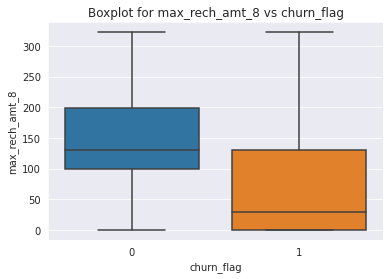

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'max_rech_amt_8').set_title('Boxplot for max_rech_amt_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['max_rech_amt_eight_below_100'] = np.where(train_imp['max_rech_amt_8']<100, 1,0)
X_test_imp['max_rech_amt_eight_below_100'] = np.where(X_test_imp['max_rech_amt_8']<100, 1,0)

### Treating total_rech_amt_8

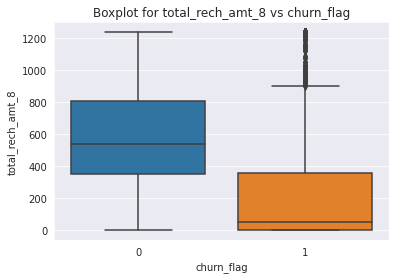

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'total_rech_amt_8').set_title('Boxplot for total_rech_amt_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['total_rech_amt_eight_below_300'] = np.where(train_imp['total_rech_amt_8']<300, 1,0)
X_test_imp['total_rech_amt_eight_below_300'] = np.where(X_test_imp['total_rech_amt_8']<300, 1,0)

### Treating total_rech_num_8

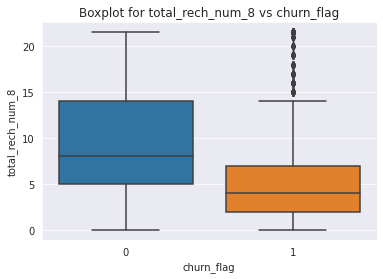

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'total_rech_num_8').set_title('Boxplot for total_rech_num_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['total_rech_num_eight_below_8'] = np.where(train_imp['total_rech_num_8']<8, 1,0)
X_test_imp['total_rech_num_eight_below_8'] = np.where(X_test_imp['total_rech_num_8']<8, 1,0)

### Treating total_ic_mou_8

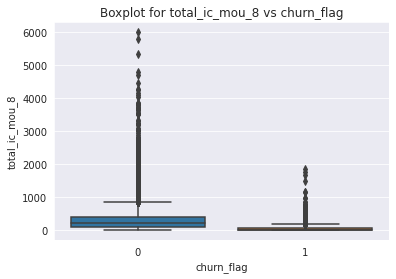

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'total_ic_mou_8').set_title('Boxplot for total_ic_mou_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['total_ic_mou_eight_below_100'] = np.where(train_imp['total_ic_mou_8']<100, 1,0)
X_test_imp['total_ic_mou_eight_below_100'] = np.where(X_test_imp['total_ic_mou_8']<100, 1,0)

### Treating loc_ic_mou_8

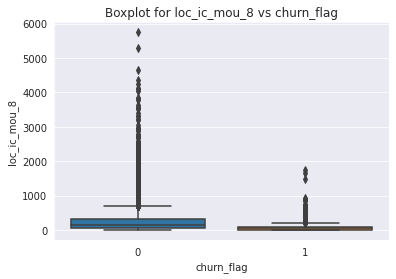

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'loc_ic_mou_8').set_title('Boxplot for loc_ic_mou_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['loc_ic_mou_eight_below_100'] = np.where(train_imp['loc_ic_mou_8']<100, 1,0)
X_test_imp['loc_ic_mou_eight_below_100'] = np.where(X_test_imp['loc_ic_mou_8']<100, 1,0)

### Treating total_og_mou_8

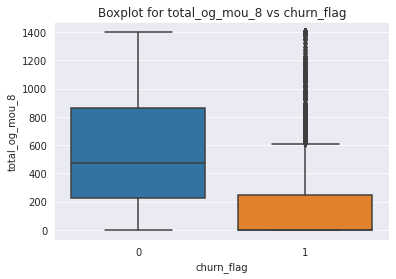

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'total_og_mou_8').set_title('Boxplot for total_og_mou_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['total_og_mou_eight_below_250'] = np.where(train_imp['total_og_mou_8']<250, 1,0)
X_test_imp['total_og_mou_eight_below_250'] = np.where(X_test_imp['total_og_mou_8']<250, 1,0)

### Treating loc_og_mou_8

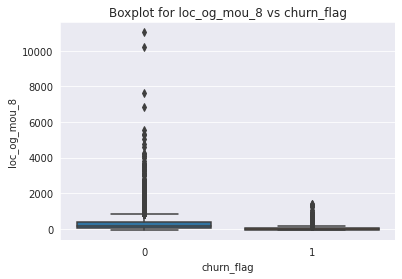

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'loc_og_mou_8').set_title('Boxplot for loc_og_mou_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['loc_og_mou_eight_below_100'] = np.where(train_imp['loc_og_mou_8']<100, 1,0)
X_test_imp['loc_og_mou_eight_below_100'] = np.where(X_test_imp['loc_og_mou_8']<100, 1,0)

### Treating loc_og_t2m_mou_8

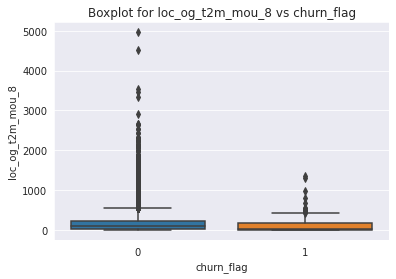

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'loc_og_t2m_mou_8').set_title('Boxplot for loc_og_t2m_mou_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['loc_og_t2m_mou_eight_below_50'] = np.where(train_imp['loc_og_t2m_mou_8']<50, 1,0)
X_test_imp['loc_og_t2m_mou_eight_below_50'] = np.where(X_test_imp['loc_og_t2m_mou_8']<50, 1,0)

### Treating loc_og_t2m_mou_7

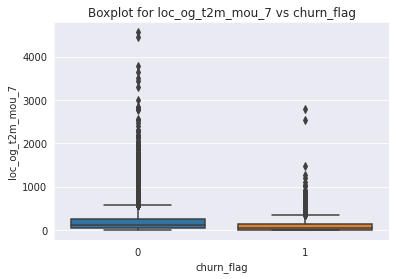

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'loc_og_t2m_mou_7').set_title('Boxplot for loc_og_t2m_mou_7 vs churn_flag')
plt.show()

In [ ]:
train_imp['loc_og_t2m_mou_seven_below_100'] = np.where(train_imp['loc_og_t2m_mou_7']<100, 1,0)
X_test_imp['loc_og_t2m_mou_seven_below_100'] = np.where(X_test_imp['loc_og_t2m_mou_7']<100, 1,0)

### Treating offnet_mou_8

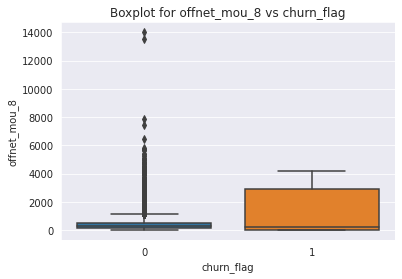

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'offnet_mou_8').set_title('Boxplot for offnet_mou_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['offnet_mou_eight_below_200'] = np.where(train_imp['offnet_mou_8']<200, 1,0)
X_test_imp['offnet_mou_eight_below_200'] = np.where(X_test_imp['offnet_mou_8']<200, 1,0)

### Treating arpu_8

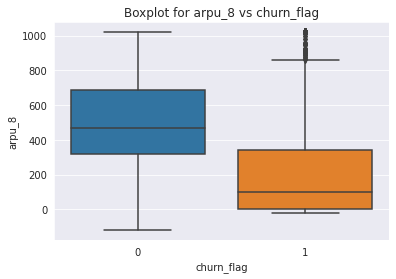

In [ ]:
sns.boxplot(data = train_imp, x = 'churn_flag', y = 'arpu_8').set_title('Boxplot for arpu_8 vs churn_flag')
plt.show()

In [ ]:
train_imp['arpu_eight_below_250'] = np.where(train_imp['arpu_8']<250, 1,0)
X_test_imp['arpu_eight_below_250'] = np.where(X_test_imp['arpu_8']<250, 1,0)

In [ ]:
y_train = train_imp['churn_flag']
X_train_imp = train_imp.drop('churn_flag', axis = 1)

## Creating difference columns between good and action phases and also specifically for good phase.

#### Features for amt information

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('amt_8')]

Index(['total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8'], dtype='object')

In [ ]:
for col in X_train_imp.columns[X_train_imp.columns.str.contains('amt_8')]:
  prefix = str(col).split('amt_8')[0]
  prefix_six = prefix + 'amt_6'
  prefix_seven = prefix + 'amt_7'
  prefix_diff = prefix + 'amt_diff'
  prefix_diff_good = prefix + 'amt_diff_good'
  
  X_train_imp[prefix_diff] = X_train_imp[col] - (X_train_imp[prefix_six] + X_train_imp[prefix_seven])/2
  X_train_imp[prefix_diff_good] = X_train_imp[prefix_seven] - X_train_imp[prefix_six]
  X_train_imp[prefix_diff+'_neg'] = np.where(X_train_imp[prefix_diff]<0, 1, 0)
  X_train_imp[prefix_diff_good+'_neg'] = np.where(X_train_imp[prefix_diff_good]<0, 1, 0)

  X_test_imp[prefix_diff] = X_test_imp[col] - (X_test_imp[prefix_six] + X_test_imp[prefix_seven])/2
  X_test_imp[prefix_diff_good] = X_test_imp[prefix_seven] - X_test_imp[prefix_six]
  X_test_imp[prefix_diff+'_neg'] = np.where(X_test_imp[prefix_diff]<0, 1, 0)
  X_test_imp[prefix_diff_good+'_neg'] = np.where(X_test_imp[prefix_diff_good]<0, 1, 0)
  #X_train_imp.drop([prefix_six, prefix_seven, col], axis = 1, inplace = True)
  #X_test_imp.drop([prefix_six, prefix_seven, col], axis = 1, inplace = True)

#### Features for minutes of usage information.

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('mou_8')]

Index(['onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8',
       'spl_og_mou_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8'],
      dtype='object')

In [ ]:
for col in X_train_imp.columns[X_train_imp.columns.str.contains('mou_8')]:
  prefix = str(col).split('mou_8')[0]
  prefix_six = prefix + 'mou_6'
  prefix_seven = prefix + 'mou_7'
  prefix_diff = prefix + 'mou_diff'
  prefix_diff_good = prefix + 'mou_diff_good'
  X_train_imp[prefix_diff] = X_train_imp[col] - (X_train_imp[prefix_six] + X_train_imp[prefix_seven])/2
  X_train_imp[prefix_diff_good] = X_train_imp[prefix_seven] - X_train_imp[prefix_six]
  X_train_imp[prefix_diff+'_neg'] = np.where(X_train_imp[prefix_diff]<0, 1, 0)
  X_train_imp[prefix_diff_good+'_neg'] = np.where(X_train_imp[prefix_diff_good]<0, 1, 0)
  X_test_imp[prefix_diff] = X_test_imp[col] - (X_test_imp[prefix_six] + X_test_imp[prefix_seven])/2
  X_test_imp[prefix_diff_good] = X_test_imp[prefix_seven] - X_test_imp[prefix_six]
  X_test_imp[prefix_diff+'_neg'] = np.where(X_test_imp[prefix_diff]<0, 1, 0)
  X_test_imp[prefix_diff_good+'_neg'] = np.where(X_test_imp[prefix_diff_good]<0, 1, 0)
  #X_train_imp.drop([prefix_six, prefix_seven, col], axis = 1, inplace = True)
  #X_test_imp.drop([prefix_six, prefix_seven, col], axis = 1, inplace = True)

#### Features for average returns per user information

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('arpu')]

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_eight_below_250'], dtype='object')

In [ ]:
X_train_imp['arpu_diff'] = X_train_imp['arpu_8'] - (X_train_imp['arpu_6'] + X_train_imp['arpu_7'])/2
X_train_imp['arpu_diff_good'] = X_train_imp['arpu_7'] - X_train_imp['arpu_6']
X_train_imp['arpu_diff_neg'] = np.where(X_train_imp['arpu_diff'] < 0, 1, 0)
X_train_imp['arpu_diff_good_neg'] = np.where(X_train_imp['arpu_diff_good'] < 0, 1, 0)
X_test_imp['arpu_diff'] = X_test_imp['arpu_8'] - (X_test_imp['arpu_6'] + X_test_imp['arpu_7'])/2
X_test_imp['arpu_diff_good'] = X_test_imp['arpu_7'] - X_test_imp['arpu_6']
X_test_imp['arpu_diff_neg'] = np.where(X_test_imp['arpu_diff'] < 0, 1, 0)
X_test_imp['arpu_diff_good_neg'] = np.where(X_test_imp['arpu_diff_good'] < 0, 1, 0)
#X_train_imp.drop(['arpu_6', 'arpu_7', 'arpu_8'], axis = 1, inplace = True)
#X_test_imp.drop(['arpu_6', 'arpu_7', 'arpu_8'], axis = 1, inplace = True)

#### Creating total minutes of usage column and the calculating metrics per minute

In [ ]:
"""
X_train_imp['total_mou_8'] = X_train_imp['total_ic_mou_8'] + X_train_imp['total_og_mou_8'] + X_train_imp['onnet_mou_8'] + X_train_imp['offnet_mou_8']
X_train_imp['total_mou_7'] = X_train_imp['total_ic_mou_7'] + X_train_imp['total_og_mou_7'] + X_train_imp['onnet_mou_7'] + X_train_imp['offnet_mou_7']
X_train_imp['total_mou_6'] = X_train_imp['total_ic_mou_6'] + X_train_imp['total_og_mou_6'] + X_train_imp['onnet_mou_6'] + X_train_imp['offnet_mou_6']

X_test_imp['total_mou_8'] = X_test_imp['total_ic_mou_8'] + X_test_imp['total_og_mou_8'] + X_test_imp['onnet_mou_8'] + X_test_imp['offnet_mou_8']
X_test_imp['total_mou_7'] = X_test_imp['total_ic_mou_7'] + X_test_imp['total_og_mou_7'] + X_test_imp['onnet_mou_7'] + X_test_imp['offnet_mou_7']
X_test_imp['total_mou_6'] = X_test_imp['total_ic_mou_6'] + X_test_imp['total_og_mou_6'] + X_test_imp['onnet_mou_6'] + X_test_imp['offnet_mou_6']
"""

X_train_imp['total_mou_8'] = X_train_imp['total_ic_mou_8'] + X_train_imp['total_og_mou_8']
X_train_imp['total_mou_7'] = X_train_imp['total_ic_mou_7'] + X_train_imp['total_og_mou_7']
X_train_imp['total_mou_6'] = X_train_imp['total_ic_mou_6'] + X_train_imp['total_og_mou_6']

X_test_imp['total_mou_8'] = X_test_imp['total_ic_mou_8'] + X_test_imp['total_og_mou_8']
X_test_imp['total_mou_7'] = X_test_imp['total_ic_mou_7'] + X_test_imp['total_og_mou_7']
X_test_imp['total_mou_6'] = X_test_imp['total_ic_mou_6'] + X_test_imp['total_og_mou_6']

X_train_imp['arpu_per_min_8'] = X_train_imp['arpu_8'] / (X_train_imp['total_mou_8'] + 1)
X_train_imp['arpu_per_min_7'] = X_train_imp['arpu_7'] / (X_train_imp['total_mou_7'] + 1)
X_train_imp['arpu_per_min_6'] = X_train_imp['arpu_6'] / (X_train_imp['total_mou_6'] + 1)

X_test_imp['arpu_per_min_8'] = X_test_imp['arpu_8'] / (X_test_imp['total_mou_8'] + 1)
X_test_imp['arpu_per_min_7'] = X_test_imp['arpu_7'] / (X_test_imp['total_mou_7'] + 1)
X_test_imp['arpu_per_min_6'] = X_test_imp['arpu_6'] / (X_test_imp['total_mou_6'] + 1)

X_train_imp['arpu_per_min_diff'] = X_train_imp['arpu_per_min_8'] - (X_train_imp['arpu_per_min_6'] + X_train_imp['arpu_per_min_7'])/2
X_train_imp['arpu_per_min_diff_good'] = X_train_imp['arpu_per_min_7'] - X_train_imp['arpu_per_min_6']
X_train_imp['arpu_per_min_diff_neg'] = np.where(X_train_imp['arpu_per_min_diff'] < 0, 1, 0)
X_train_imp['arpu_per_min_diff_good_neg'] = np.where(X_train_imp['arpu_per_min_diff_good'] < 0, 1, 0)

X_test_imp['arpu_per_min_diff'] = X_test_imp['arpu_per_min_8'] - (X_test_imp['arpu_per_min_6'] + X_test_imp['arpu_per_min_7'])/2
X_test_imp['arpu_per_min_diff_good'] = X_test_imp['arpu_per_min_7'] - X_test_imp['arpu_per_min_6']
X_test_imp['arpu_per_min_diff_neg'] = np.where(X_test_imp['arpu_per_min_diff'] < 0, 1, 0)
X_test_imp['arpu_per_min_diff_good_neg'] = np.where(X_test_imp['arpu_per_min_diff_good'] < 0, 1, 0)

#### Total revenue per user features

In [ ]:
X_train_imp['trpu_8'] = X_train_imp['arpu_8'] * (X_train_imp['total_mou_8'] + 1)
X_train_imp['trpu_7'] = X_train_imp['arpu_7'] * (X_train_imp['total_mou_7'] + 1)
X_train_imp['trpu_6'] = X_train_imp['arpu_6'] * (X_train_imp['total_mou_6'] + 1)

X_test_imp['trpu_8'] = X_test_imp['arpu_8'] * (X_test_imp['total_mou_8'] + 1)
X_test_imp['trpu_7'] = X_test_imp['arpu_7'] * (X_test_imp['total_mou_7'] + 1)
X_test_imp['trpu_6'] = X_test_imp['arpu_6'] * (X_test_imp['total_mou_6'] + 1)

X_train_imp['trpu_diff'] = X_train_imp['trpu_8'] - (X_train_imp['trpu_6'] + X_train_imp['trpu_7'])/2
X_train_imp['trpu_diff_good'] = X_train_imp['trpu_7'] - X_train_imp['trpu_6']
X_train_imp['trpu_diff_neg'] = np.where(X_train_imp['trpu_diff'] < 0, 1, 0)
X_train_imp['trpu_diff_good_neg'] = np.where(X_train_imp['trpu_diff_good'] < 0, 1, 0)

X_test_imp['trpu_diff'] = X_test_imp['trpu_8'] - (X_test_imp['trpu_6'] + X_test_imp['trpu_7'])/2
X_test_imp['trpu_diff_good'] = X_test_imp['trpu_7'] - X_test_imp['trpu_6']
X_test_imp['trpu_diff_neg'] = np.where(X_test_imp['trpu_diff'] < 0, 1, 0)
X_test_imp['trpu_diff_good_neg'] = np.where(X_test_imp['trpu_diff_good'] < 0, 1, 0)

#### Features for vbc information

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('vbc')]


Index(['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'], dtype='object')

In [ ]:
X_train_imp['vbc_diff'] = X_train_imp['aug_vbc_3g'] - (X_train_imp['jun_vbc_3g'] + X_train_imp['jul_vbc_3g'])/2
X_train_imp['vbc_diff_good'] = X_train_imp['jul_vbc_3g'] - X_train_imp['jun_vbc_3g']
X_train_imp['vbc_diff_neg'] = np.where(X_train_imp['vbc_diff'] < 0, 1, 0)
X_train_imp['vbc_diff_neg_good'] = np.where(X_train_imp['vbc_diff_good'] < 0, 1, 0)
X_test_imp['vbc_diff'] = X_test_imp['aug_vbc_3g'] - (X_test_imp['jun_vbc_3g'] + X_test_imp['jul_vbc_3g'])/2
X_test_imp['vbc_diff_good'] = X_test_imp['jul_vbc_3g'] - X_test_imp['jun_vbc_3g']
X_test_imp['vbc_diff_neg'] = np.where(X_test_imp['vbc_diff'] < 0, 1, 0)
X_test_imp['vbc_diff_neg_good'] = np.where(X_test_imp['vbc_diff_good'] < 0, 1, 0)

#### Features for sachet inforamtion

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('sachet')]

Index(['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8'],
      dtype='object')

In [ ]:
for col in ['sachet_2g_8', 'sachet_3g_8']:
  prefix = str(col).split('_8')[0]
  prefix_six = prefix + '_6'
  prefix_seven = prefix + '_7'
  prefix_diff = prefix + '_diff'
  prefix_diff_good = prefix + '_diff_good'
  X_train_imp[prefix_diff] = X_train_imp[col] - (X_train_imp[prefix_six] + X_train_imp[prefix_seven])/2
  X_train_imp[prefix_diff_good] = X_train_imp[prefix_seven] - X_train_imp[prefix_six]
  X_train_imp[prefix_diff+'_neg'] = np.where(X_train_imp[prefix_diff]<0, 1, 0)
  X_train_imp[prefix_diff_good+'_neg'] = np.where(X_train_imp[prefix_diff_good]<0, 1, 0)
  X_test_imp[prefix_diff] = X_test_imp[col] - (X_test_imp[prefix_six] + X_test_imp[prefix_seven])/2
  X_test_imp[prefix_diff_good] = X_test_imp[prefix_seven] - X_test_imp[prefix_six]
  X_test_imp[prefix_diff+'_neg'] = np.where(X_test_imp[prefix_diff]<0, 1, 0)
  X_test_imp[prefix_diff_good+'_neg'] = np.where(X_test_imp[prefix_diff_good]<0, 1, 0)


#### Features for monthly information

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('monthly')]

Index(['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6',
       'monthly_3g_7', 'monthly_3g_8'],
      dtype='object')

In [ ]:
for col in ['monthly_2g_8', 'monthly_3g_8']:
  prefix = str(col).split('_8')[0]
  prefix_six = prefix + '_6'
  prefix_seven = prefix + '_7'
  prefix_diff = prefix + '_diff'
  prefix_diff_good = prefix + '_diff_good'
  X_train_imp[prefix_diff] = X_train_imp[col] - (X_train_imp[prefix_six] + X_train_imp[prefix_seven])/2
  X_train_imp[prefix_diff_good] = X_train_imp[prefix_seven] - X_train_imp[prefix_six]
  X_train_imp[prefix_diff+'_neg'] = np.where(X_train_imp[prefix_diff]<0, 1, 0)
  X_train_imp[prefix_diff_good+'_neg'] = np.where(X_train_imp[prefix_diff_good]<0, 1, 0)
  X_test_imp[prefix_diff] = X_test_imp[col] - (X_test_imp[prefix_six] + X_test_imp[prefix_seven])/2
  X_test_imp[prefix_diff_good] = X_test_imp[prefix_seven] - X_test_imp[prefix_six]
  X_test_imp[prefix_diff+'_neg'] = np.where(X_test_imp[prefix_diff]<0, 1, 0)
  X_test_imp[prefix_diff_good+'_neg'] = np.where(X_test_imp[prefix_diff_good]<0, 1, 0)

#### Features for volume information

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('vol')]

Index(['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8'],
      dtype='object')

In [ ]:
for col in ['vol_2g_mb_8', 'vol_3g_mb_8']:
  prefix = str(col).split('_8')[0]
  prefix_six = prefix + '_6'
  prefix_seven = prefix + '_7'
  prefix_diff = prefix + '_diff'
  prefix_diff_good = prefix + '_diff_good'
  X_train_imp[prefix_diff] = X_train_imp[col] - (X_train_imp[prefix_six] + X_train_imp[prefix_seven])/2
  X_train_imp[prefix_diff_good] = X_train_imp[prefix_seven] - X_train_imp[prefix_six]
  X_train_imp[prefix_diff+'_neg'] = np.where(X_train_imp[prefix_diff]<0, 1, 0)
  X_train_imp[prefix_diff_good+'_neg'] = np.where(X_train_imp[prefix_diff_good]<0, 1, 0)
  X_test_imp[prefix_diff] = X_test_imp[col] - (X_test_imp[prefix_six] + X_test_imp[prefix_seven])/2
  X_test_imp[prefix_diff_good] = X_test_imp[prefix_seven] - X_test_imp[prefix_six]
  X_test_imp[prefix_diff+'_neg'] = np.where(X_test_imp[prefix_diff]<0, 1, 0)
  X_test_imp[prefix_diff_good+'_neg'] = np.where(X_test_imp[prefix_diff_good]<0, 1, 0)

#### Features for data related information

In [ ]:
X_train_imp.columns[X_train_imp.columns.str.contains('data_8')]

Index(['date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8'], dtype='object')

In [ ]:
for col in X_train_imp.columns[X_train_imp.columns.str.contains('data_8')]:
  prefix = str(col).split('data_8')[0]
  prefix_six = prefix + 'data_6'
  prefix_seven = prefix + 'data_7'
  prefix_diff = prefix + 'data_diff'
  prefix_diff_good = prefix + 'data_diff_good'
  X_train_imp[prefix_diff] = X_train_imp[col] - (X_train_imp[prefix_six] + X_train_imp[prefix_seven])/2
  X_train_imp[prefix_diff_good] = X_train_imp[prefix_seven] - X_train_imp[prefix_six]
  X_train_imp[prefix_diff+'_neg'] = np.where(X_train_imp[prefix_diff]<0, 1, 0)
  X_train_imp[prefix_diff_good+'_neg'] = np.where(X_train_imp[prefix_diff_good]<0, 1, 0)
  X_test_imp[prefix_diff] = X_test_imp[col] - (X_test_imp[prefix_six] + X_test_imp[prefix_seven])/2
  X_test_imp[prefix_diff_good] = X_test_imp[prefix_seven] - X_test_imp[prefix_six]
  X_test_imp[prefix_diff+'_neg'] = np.where(X_test_imp[prefix_diff]<0, 1, 0)
  X_test_imp[prefix_diff_good+'_neg'] = np.where(X_test_imp[prefix_diff_good]<0, 1, 0)

In [ ]:
X_train_imp.shape

(21007, 338)

In [ ]:
X_test_imp.shape


(9004, 338)

### Applying yeo johnson transformation to non normal numeric columns

In [ ]:
for cols in X_train_imp.columns:
  if (len(X_train_imp[cols].unique()) > 2):
    stats, pval = shapiro(X_train_imp[cols].sample(100))
    if pval <= 0.05:
      ptransf = PowerTransformer(standardize=False)
      train_val = ptransf.fit_transform(np.array(X_train_imp[cols]).reshape(-1,1))
      test_val = ptransf.transform(np.array(X_test_imp[cols]).reshape(-1,1))
      X_train_imp[str(cols)+'_ptransf'] = train_val
      X_test_imp[str(cols)+'_ptransf'] = test_val
      print('Transformed:', cols)
      X_train_imp.drop(cols, axis = 1, inplace = True) 
      X_test_imp.drop(cols, axis = 1, inplace = True)
      print(cols, pval)

Transformed: arpu_6
arpu_6 0.001485292101278901
Transformed: arpu_7
arpu_7 4.839223304755701e-18
Transformed: arpu_8
arpu_8 1.8768763766274787e-05
Transformed: onnet_mou_6
onnet_mou_6 1.549016796247222e-17
Transformed: onnet_mou_7
onnet_mou_7 3.305495519380868e-16
Transformed: onnet_mou_8
onnet_mou_8 1.1283577353280751e-17
Transformed: offnet_mou_6
offnet_mou_6 2.336191240459584e-09
Transformed: offnet_mou_7
offnet_mou_7 9.367492211895977e-17
Transformed: offnet_mou_8
offnet_mou_8 7.295283863497422e-15
Transformed: roam_ic_mou_6
roam_ic_mou_6 1.0271740630782399e-20
Transformed: roam_ic_mou_7
roam_ic_mou_7 4.191092165493764e-20
Transformed: roam_ic_mou_8
roam_ic_mou_8 6.124421344653035e-20
Transformed: roam_og_mou_6
roam_og_mou_6 1.713750311545525e-18
Transformed: roam_og_mou_7
roam_og_mou_7 1.0635831447539717e-19
Transformed: roam_og_mou_8
roam_og_mou_8 5.355960135054259e-22
Transformed: loc_og_t2t_mou_6
loc_og_t2t_mou_6 3.6208707672364694e-16
Transformed: loc_og_t2t_mou_7
loc_og_t2t_m

### Applying scaling and sampling techniques to look after class imbalance

In [ ]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns = X_train_imp.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns = X_test_imp.columns)

In [ ]:
smote = SVMSMOTE(sampling_strategy=0.7)
X_train_scaled, y_train_resamp = smote.fit_resample(X_train_scaled ,y_train)


In [ ]:
np.sum(y_train_resamp)/len(y_train_resamp)

0.4117574940231717

In [ ]:
len(X_train_imp.columns)

338

In [ ]:
pca = PCA()

In [ ]:
pca.fit(X_train_scaled)

PCA()

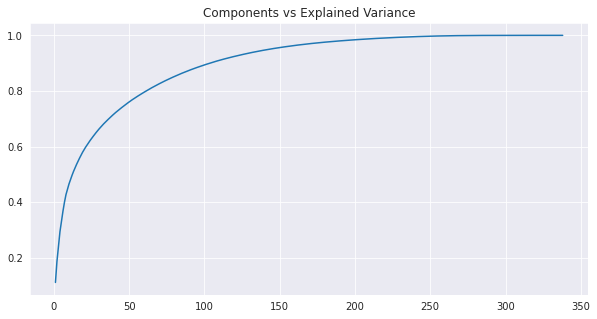

In [ ]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize = (10,5))
fig = sns.lineplot(x = [i+1 for i in range(len(cum_variance))], y = cum_variance)
fig.set_title('Components vs Explained Variance')
plt.show()                       

In [ ]:
pca.components_

array([[-1.16514284e-19, -5.55111512e-17, -1.66533454e-16, ...,
        -2.12994934e-02, -3.36358530e-02, -2.97996919e-02],
       [-3.94216054e-19, -1.66533454e-16, -4.44089210e-16, ...,
         5.59791216e-03,  3.11189825e-02,  1.69667559e-02],
       [ 3.56695963e-19,  8.32667268e-17, -2.77555756e-16, ...,
        -2.83254636e-02, -2.09580460e-02, -3.09769869e-02],
       ...,
       [ 0.00000000e+00, -8.24374089e-02,  4.31384802e-02, ...,
        -2.42861287e-17, -1.38777878e-17,  1.80411242e-16],
       [ 9.99985073e-01,  1.21366026e-03, -3.69412533e-03, ...,
        -5.20417043e-18, -1.73472348e-18, -2.87313576e-18],
       [ 0.00000000e+00, -1.71433185e-01,  8.98531863e-02, ...,
         7.63278329e-17,  4.16333634e-17, -4.16333634e-17]])

In [ ]:
X_test_scaled.shape

(9004, 338)

### Using 99% of available information

In [ ]:
pca = PCA(n_components = 0.99)
X_train_std_pca = pca.fit_transform(X_train_scaled)
X_test_std_pca = pca.transform(X_test_scaled)

In [ ]:
X_train_std_pca.shape

(32626, 218)

In [ ]:
pca_columns = ['pca_'+str(i+1) for i in range(X_train_std_pca.shape[1])]

In [ ]:
X_train_std_pca = pd.DataFrame(X_train_std_pca, columns = pca_columns)
X_test_std_pca = pd.DataFrame(X_test_std_pca, columns = pca_columns)

In [ ]:

X_train_std_pca_exp = X_train_std_pca
X_test_std_pca_exp = X_test_std_pca

In [ ]:
start = time.time()
classifier = RandomForestClassifier(n_estimators = 200, class_weight='balanced_subsample', n_jobs = -1, verbose = 3)
folds = 3
param_grid = {
    'max_depth' : [10,20,50,70]
}
scorer = make_scorer(roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)
model = GridSearchCV(estimator = classifier, param_grid=param_grid, n_jobs=-1,  scoring = scorer, cv = folds, verbose = 5)
model.fit(X_train_std_pca_exp.values, y_train_resamp)
end = time.time()
print('Total time is: ',str(end - start))
print(model.best_score_)
print(model.best_params_)
y_pred = model.predict(X_train_std_pca_exp.values)
print(classification_report(y_true=y_train_resamp, y_pred=y_pred))




Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.4s


building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   51.5s


building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Total time is:  642.2108824253082
0.9834589869633549
{'max_depth': 50}


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.7s


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19192
           1       1.00      1.00      1.00     13434

    accuracy                           1.00     32626
   macro avg       1.00      1.00      1.00     32626
weighted avg       1.00      1.00      1.00     32626



[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    1.0s finished


In [ ]:
print(accuracy_score(y_true=y_train_resamp, y_pred=y_pred))

0.9999693495984797


In [ ]:
print(precision_score(y_true=y_train_resamp, y_pred=y_pred))

0.9999255675474507


In [ ]:
print(recall_score(y_true=y_train_resamp, y_pred=y_pred))

1.0


In [ ]:
y_pred = model.predict(X_test_std_pca_exp.values)
#y_pred = model.predict(X_test_std_pca.values)
print(classification_report(y_true=y_test, y_pred=y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8226
           1       0.59      0.43      0.50       778

    accuracy                           0.93      9004
   macro avg       0.77      0.70      0.73      9004
weighted avg       0.92      0.93      0.92      9004



[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.9253665037760995


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.5936395759717314


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.4318766066838046


In [ ]:
y_probs = model.predict_proba(X_test_std_pca_exp.values)[:,1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


In [ ]:
model.classes_

array([0, 1])

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(7, 7))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

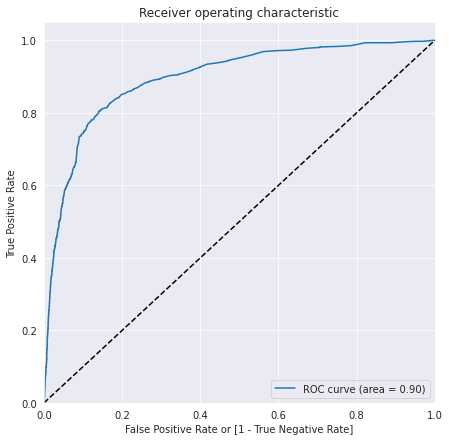

In [ ]:
draw_roc(y_test, y_probs)

In [ ]:
threshold_df = pd.DataFrame({'Churn':y_test, 'probabilities':y_probs})
for i in np.arange(0,1,0.05):
    i = round(i,2)
    threshold_df[i] = threshold_df['probabilities'].apply(lambda x: 1 if x >= i else 0)
threshold_df   

,Churn,probabilities,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
18478,0,0.090000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81980,0,0.035000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61120,1,0.310000,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
30976,0,0.075000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67624,0,0.165000,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51844,0,0.130000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56960,1,0.314971,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
30332,0,0.274947,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49678,0,0.130000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
accuracy = []
speci = []
sensi = []
cutoffs = []

for i in np.arange(0,1,0.05):
    i = round(i,2)
    cutoffs.append(i)
    cm1 = confusion_matrix(threshold_df.Churn, threshold_df[i] )
    total1=sum(sum(cm1))
    accuracy.append((cm1[0,0]+cm1[1,1])/total1)
    speci.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    sensi.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
cutoff_data = pd.DataFrame({'thresholds':cutoffs, 'accuracy':accuracy, 'specificity': speci, 'sensitivity':sensi})
cutoff_data

,thresholds,accuracy,specificity,sensitivity
0,0.00,0.086406,0.000000,1.000000
1,0.05,0.248445,0.177972,0.993573
2,0.10,0.565082,0.529297,0.943445
3,0.15,0.734340,0.719548,0.890746
4,0.20,0.812417,0.809628,0.841902
5,0.25,0.863283,0.870289,0.789203
6,0.30,0.894602,0.909798,0.733933
7,0.35,0.908485,0.936300,0.614396
8,0.40,0.918481,0.953440,0.548843
9,0.45,0.921479,0.962922,0.483290


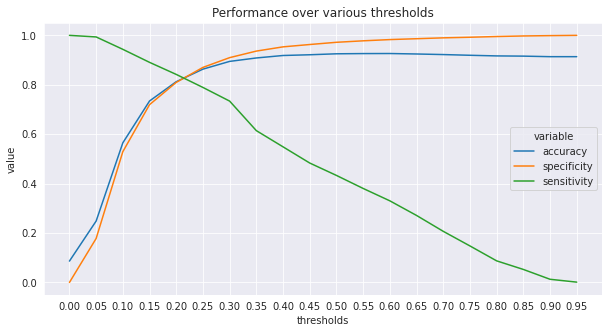

In [ ]:
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='thresholds', y='value', hue='variable', data=pd.melt(cutoff_data, ['thresholds']))
ax.set_title('Performance over various thresholds')
ax.set_xticks(cutoff_data.thresholds)
plt.show()

In [ ]:
p, r, threshold = precision_recall_curve(y_true = threshold_df['Churn'], probas_pred = threshold_df['probabilities'])

In [ ]:
pr_df = pd.DataFrame({'Threshold':threshold, 'Precision':p[:-1], 'Recall':r[:-1]})
pr_df['diff'] = np.abs(pr_df['Recall'] - pr_df['Precision'])
pr_df.sort_values(by = 'diff')

,Threshold,Precision,Recall,diff
824,0.410000,0.534615,0.535990,0.001374
823,0.409976,0.533931,0.535990,0.002059
822,0.409969,0.534527,0.537275,0.002748
825,0.414016,0.536176,0.533419,0.002757
821,0.409955,0.533844,0.537275,0.003431
...,...,...,...,...
3,0.025000,0.088787,0.997429,0.908642
2,0.024918,0.088777,0.997429,0.908652
1,0.020000,0.087668,0.998715,0.911047
0,0.015000,0.086947,1.000000,0.913053


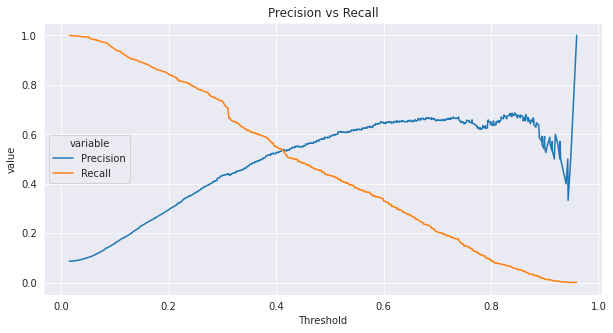

In [ ]:
pr_df_plot = pr_df.drop('diff', axis = 1)
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(pr_df_plot, ['Threshold']))
ax.set_title('Precision vs Recall')
plt.show()

### Predictions with optimum threshold

In [ ]:
opt_thresh = pr_df[pr_df['Threshold'] < 0.98].sort_values(by = ['diff', 'Threshold']).iloc[0,0]
opt_thresh

0.41

In [ ]:
y_pred = list(map(lambda x: 1 if x >= opt_thresh else 0, y_probs))

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8226
           1       0.53      0.54      0.54       778

    accuracy                           0.92      9004
   macro avg       0.75      0.75      0.75      9004
weighted avg       0.92      0.92      0.92      9004



In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.9195912927587738


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.5346153846153846


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.5359897172236504


In [ ]:
f1_score_rf = f1_score(y_true=y_test, y_pred=y_pred)
print(f1_score_rf)

0.5353016688061618


### Trying out KNN

In [ ]:
start = time.time()
classifier = KNeighborsClassifier(n_jobs = -1)
folds = 3
param_grid = {
    'n_neighbors' : [3, 5, 10, 15],
    'weights': ['uniform', 'distance']
}
scorer = make_scorer(roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)
model = GridSearchCV(estimator = classifier, param_grid=param_grid, n_jobs=-1,  scoring = scorer, cv = folds, verbose = 5)
model.fit(X_train_std_pca_exp.values, y_train_resamp)
end = time.time()
print('Total time is: ',str(end - start))
print(model.best_score_)
print(model.best_params_)
y_pred = model.predict(X_train_std_pca_exp.values)
print(classification_report(y_true=y_train_resamp, y_pred=y_pred))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Total time is:  141.9465389251709
0.9642661108990462
{'n_neighbors': 15, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19192
           1       1.00      1.00      1.00     13434

    accuracy                           1.00     32626
   macro avg       1.00      1.00      1.00     32626
weighted avg       1.00      1.00      1.00     32626



In [ ]:
print(accuracy_score(y_true=y_train_resamp, y_pred=y_pred))

1.0


In [ ]:
print(precision_score(y_true=y_train_resamp, y_pred=y_pred))

1.0


In [ ]:
print(recall_score(y_true=y_train_resamp, y_pred=y_pred))

1.0


In [ ]:
y_pred = model.predict(X_test_std_pca_exp.values)
#y_pred = model.predict(X_test_std_pca.values)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      8226
           1       0.27      0.85      0.41       778

    accuracy                           0.79      9004
   macro avg       0.62      0.81      0.64      9004
weighted avg       0.92      0.79      0.83      9004



In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.7853176366059529


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.26628895184135976


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.8457583547557841


In [ ]:
#y_probs = model.predict_proba(X_test_std_pca.values)[:,1]
y_probs = model.predict_proba(X_test_std_pca_exp.values)[:,1]

In [ ]:
model.classes_

array([0, 1])

#### Analysing the model

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

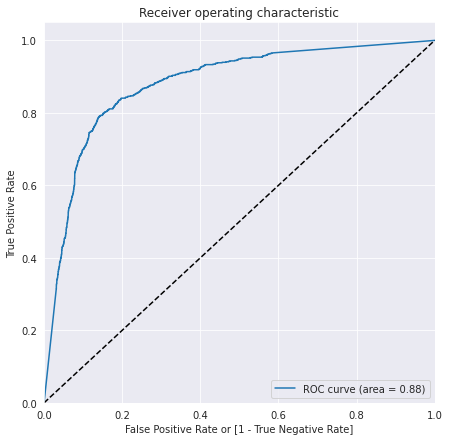

In [ ]:
draw_roc(y_test, y_probs)

In [ ]:
threshold_df = pd.DataFrame({'Churn':y_test, 'probabilities':y_probs})
for i in np.arange(0,1,0.05):
    i = round(i,2)
    threshold_df[i] = threshold_df['probabilities'].apply(lambda x: 1 if x >= i else 0)
threshold_df   

,Churn,probabilities,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
18478,0,0.200693,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81980,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61120,1,0.866275,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
30976,0,0.064120,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67624,0,0.734783,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51844,0,0.328641,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
56960,1,0.733697,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
30332,0,0.802322,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
49678,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
accuracy = []
speci = []
sensi = []
cutoffs = []

for i in np.arange(0,1,0.05):
    i = round(i,2)
    cutoffs.append(i)
    cm1 = confusion_matrix(threshold_df.Churn, threshold_df[i] )
    total1=sum(sum(cm1))
    accuracy.append((cm1[0,0]+cm1[1,1])/total1)
    speci.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    sensi.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
cutoff_data = pd.DataFrame({'thresholds':cutoffs, 'accuracy':accuracy, 'specificity': speci, 'sensitivity':sensi})
cutoff_data

,thresholds,accuracy,specificity,sensitivity
0,0.00,0.086406,0.000000,1.000000
1,0.05,0.464460,0.417092,0.965296
2,0.10,0.561861,0.525894,0.942159
3,0.15,0.618725,0.589229,0.930591
4,0.20,0.652266,0.627522,0.913882
5,0.25,0.662372,0.638828,0.911311
6,0.30,0.700800,0.681984,0.899743
7,0.35,0.730453,0.716022,0.883033
8,0.40,0.750777,0.739606,0.868895
9,0.45,0.757663,0.747386,0.866324


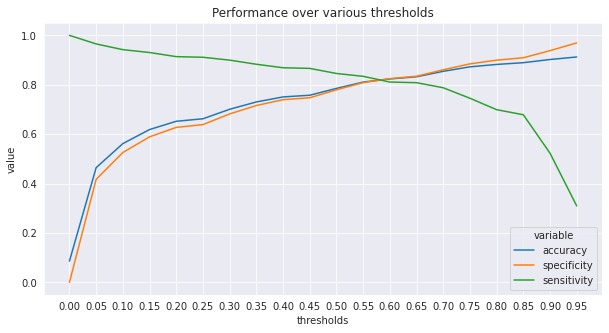

In [ ]:
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='thresholds', y='value', hue='variable', data=pd.melt(cutoff_data, ['thresholds']))
ax.set_title('Performance over various thresholds')
ax.set_xticks(cutoff_data.thresholds)
plt.show()

In [ ]:
p, r, threshold = precision_recall_curve(y_true = threshold_df['Churn'], probas_pred = threshold_df['probabilities'])

In [ ]:
pr_df = pd.DataFrame({'Threshold':threshold, 'Precision':p[:-1], 'Recall':r[:-1]})
pr_df['diff'] = np.abs(pr_df['Recall'] - pr_df['Precision'])
pr_df.sort_values(by = 'diff')

,Threshold,Precision,Recall,diff
4769,0.932241,0.452442,0.452442,0.000000
4770,0.932245,0.451737,0.451157,0.000581
4768,0.932233,0.451861,0.452442,0.000581
4767,0.932224,0.451282,0.452442,0.001160
4771,0.932251,0.452320,0.451157,0.001163
...,...,...,...,...
4,0.061556,0.135306,0.964010,0.828704
3,0.061508,0.135281,0.964010,0.828729
2,0.059635,0.135437,0.965296,0.829858
1,0.058530,0.135413,0.965296,0.829883


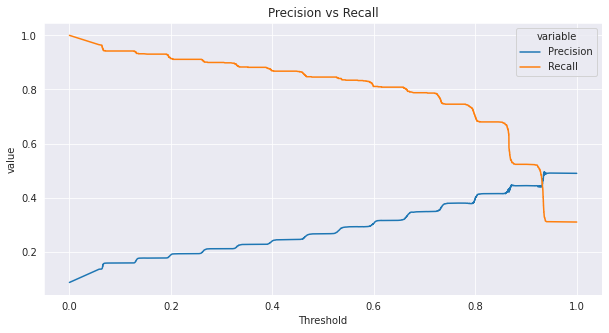

In [ ]:
pr_df_plot = pr_df.drop('diff', axis = 1)
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(pr_df_plot, ['Threshold']))
ax.set_title('Precision vs Recall')
plt.show()

### Predictions with optimum threshold

In [ ]:
opt_thresh = pr_df[pr_df['Threshold'] < 0.98].sort_values(by = ['diff', 'Threshold']).iloc[0,0]
opt_thresh

0.9322405197752259

In [ ]:
y_pred = list(map(lambda x: 1 if x >= opt_thresh else 0, y_probs))

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8226
           1       0.45      0.45      0.45       778

    accuracy                           0.91      9004
   macro avg       0.70      0.70      0.70      9004
weighted avg       0.91      0.91      0.91      9004



In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.9053753887161262


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.4524421593830334


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.4524421593830334


In [ ]:
f1_score_knn = f1_score(y_true=y_test, y_pred=y_pred)
print(f1_score_knn)

0.4524421593830334


### Trying out Logistic Regression model

In [ ]:

start = time.time()
classifier = LogisticRegression(n_jobs = -1)
folds = 3
param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'class_weight' : [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]
}
scorer = make_scorer(roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)
model = GridSearchCV(estimator = classifier, param_grid=param_grid, n_jobs=-1,  scoring = scorer, cv = folds, verbose = 5)
model.fit(X_train_std_pca, y_train_resamp)
end = time.time()
print('Total time is: ',str(end - start))
print(model.best_score_)
print(model.best_params_)
y_pred = model.predict(X_train_std_pca.values)
print(classification_report(y_true=y_train_resamp, y_pred=y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.96171403        nan 0.96164921        nan 0.96190386
        nan 0.96187068        nan 0.96178278        nan 0.961757
        nan 0.96152158        nan 0.96149758        nan 0.96114571
        nan 0.96112416]
  category=UserWarning


Total time is:  29.92413020133972
0.9619038587971459
{'class_weight': {0: 0.2, 1: 0.8}, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     19192
           1       0.83      0.97      0.89     13434

    accuracy                           0.90     32626
   macro avg       0.90      0.91      0.90     32626
weighted avg       0.92      0.90      0.91     32626



In [ ]:
print(accuracy_score(y_true=y_train_resamp, y_pred=y_pred))

0.9042787960522283


In [ ]:
print(precision_score(y_true=y_train_resamp, y_pred=y_pred))

0.826111708520463


In [ ]:
print(recall_score(y_true=y_train_resamp, y_pred=y_pred))

0.9721601905612625


In [ ]:
y_pred = model.predict(X_test_std_pca_exp.values)
#y_pred = model.predict(X_test_std_pca.values)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8226
           1       0.35      0.87      0.50       778

    accuracy                           0.85      9004
   macro avg       0.67      0.86      0.70      9004
weighted avg       0.93      0.85      0.87      9004



In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.8469569080408708


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.3469387755102041


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.8740359897172236


In [ ]:
#y_probs = model.predict_proba(X_test_std_pca.values)[:,1]
y_probs = model.predict_proba(X_test_std_pca_exp.values)[:,1]

In [ ]:
model.classes_

array([0, 1])

#### Analysing the model

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

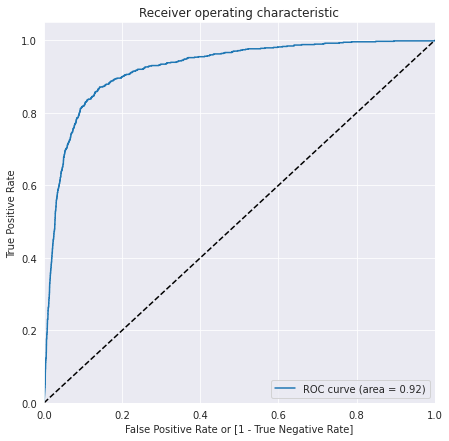

In [ ]:
draw_roc(y_test, y_probs)

In [ ]:
threshold_df = pd.DataFrame({'Churn':y_test, 'probabilities':y_probs})
for i in np.arange(0,1,0.05):
    i = round(i,2)
    threshold_df[i] = threshold_df['probabilities'].apply(lambda x: 1 if x >= i else 0)
threshold_df   

,Churn,probabilities,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
18478,0,0.022694,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81980,0,0.030851,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61120,1,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
30976,0,0.184267,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67624,0,0.594596,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51844,0,0.840867,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
56960,1,0.965655,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
30332,0,0.612027,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
49678,0,0.029232,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
accuracy = []
speci = []
sensi = []
cutoffs = []

for i in np.arange(0,1,0.05):
    i = round(i,2)
    cutoffs.append(i)
    cm1 = confusion_matrix(threshold_df.Churn, threshold_df[i] )
    total1=sum(sum(cm1))
    accuracy.append((cm1[0,0]+cm1[1,1])/total1)
    speci.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    sensi.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
cutoff_data = pd.DataFrame({'thresholds':cutoffs, 'accuracy':accuracy, 'specificity': speci, 'sensitivity':sensi})
cutoff_data

,thresholds,accuracy,specificity,sensitivity
0,0.00,0.086406,0.000000,1.000000
1,0.05,0.512994,0.469122,0.976864
2,0.10,0.629498,0.598711,0.955013
3,0.15,0.690471,0.666910,0.939589
4,0.20,0.730453,0.711524,0.930591
5,0.25,0.757441,0.741551,0.925450
6,0.30,0.779209,0.766229,0.916452
7,0.35,0.802532,0.792852,0.904884
8,0.40,0.818636,0.811330,0.895887
9,0.45,0.834185,0.829200,0.886889


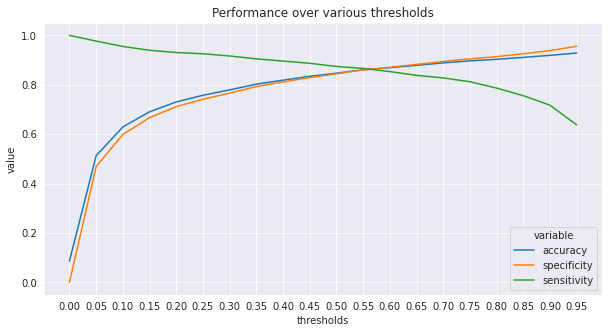

In [ ]:
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='thresholds', y='value', hue='variable', data=pd.melt(cutoff_data, ['thresholds']))
ax.set_title('Performance over various thresholds')
ax.set_xticks(cutoff_data.thresholds)
plt.show()

In [ ]:
p, r, threshold = precision_recall_curve(y_true = threshold_df['Churn'], probas_pred = threshold_df['probabilities'])

In [ ]:
pr_df = pd.DataFrame({'Threshold':threshold, 'Precision':p[:-1], 'Recall':r[:-1]})
pr_df['diff'] = np.abs(pr_df['Recall'] - pr_df['Precision'])
pr_df.sort_values(by = 'diff')

,Threshold,Precision,Recall,diff
8226,9.614537e-01,0.597686,0.597686,0.000000
8225,9.612772e-01,0.596919,0.597686,0.000767
8227,9.615679e-01,0.598456,0.597686,0.000769
8224,9.612189e-01,0.596154,0.597686,0.001533
8228,9.617436e-01,0.599227,0.597686,0.001540
...,...,...,...,...
4,1.531172e-05,0.086333,0.998715,0.912381
3,1.445021e-05,0.086324,0.998715,0.912391
2,1.177963e-05,0.086314,0.998715,0.912401
1,9.804684e-06,0.086305,0.998715,0.912410


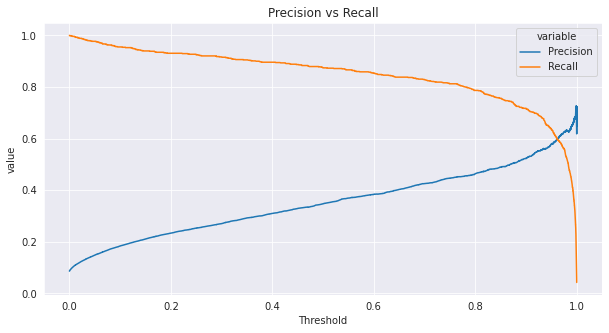

In [ ]:
pr_df_plot = pr_df.drop('diff', axis = 1)
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(pr_df_plot, ['Threshold']))
ax.set_title('Precision vs Recall')
plt.show()

### Predictions with optimum threshold

In [ ]:
opt_thresh = pr_df[pr_df['Threshold'] < 0.98].sort_values(by = ['diff', 'Threshold']).iloc[0,0]
opt_thresh

0.96145368032802

In [ ]:
y_pred = list(map(lambda x: 1 if x >= opt_thresh else 0, y_probs))

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8226
           1       0.60      0.60      0.60       778

    accuracy                           0.93      9004
   macro avg       0.78      0.78      0.78      9004
weighted avg       0.93      0.93      0.93      9004



In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.9304753442914261


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.5976863753213367


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.5976863753213367


In [ ]:
f1_score_lr = f1_score(y_true=y_test, y_pred=y_pred)
print(f1_score_lr)

0.5976863753213367


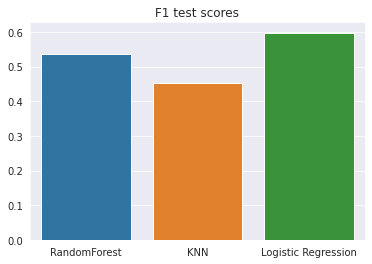

In [ ]:
sns.barplot(x = ['RandomForest', 'KNN', 'Logistic Regression'], y = [f1_score_rf, f1_score_knn, f1_score_lr]).set_title('F1 test scores')
plt.show()

## We observe that Logistic regression is able to generalize the best based on optimum threshold and should be used as the prediction model.

## Building an Interpretable model

In [ ]:
corr_df = X_train_scaled.corr().abs()

In [ ]:
unstacked_corr_df = corr_df.unstack()
unstacked_corr_df = unstacked_corr_df.sort_values(ascending = False).to_frame().rename(columns = { 0:'abs_corrs'})
unstacked_corr_df = unstacked_corr_df[unstacked_corr_df['abs_corrs']<1].copy()

#### We remove variables that are correlated with more than 5 variables with the magnitude of greater than 0.6

In [ ]:
most_frequent = unstacked_corr_df[unstacked_corr_df['abs_corrs']>0.6].reset_index()['level_0'].value_counts().to_frame()
cols_to_elim = most_frequent[most_frequent['level_0']>5].index

In [ ]:
len(cols_to_elim)

70

In [ ]:
X_train_scaled_exp = X_train_scaled.drop(cols_to_elim, axis = 1)
X_test_scaled_exp = X_test_scaled.drop(cols_to_elim, axis = 1)

In [ ]:
len(X_train_scaled.columns)

338

### We build a Random Forest model as our interpretable model

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced_subsample', n_jobs = -1)

start = time.time()
rfe = RFE(classifier, 30, step = 50, verbose = 3)
rfe = rfe.fit(X_train_scaled, y_train_resamp)
elim_df = pd.DataFrame({'Columns':X_train_scaled.columns, 'Support':rfe.support_, 'Ranking':rfe.ranking_}).sort_values(['Support', 'Ranking'])
end = time.time() - start
print(end)
elim_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting estimator with 338 features.
Fitting estimator with 288 features.
Fitting estimator with 238 features.
Fitting estimator with 188 features.
Fitting estimator with 138 features.
Fitting estimator with 88 features.
Fitting estimator with 38 features.
147.60977578163147


,Columns,Support,Ranking
16,total_og_mou_eight_below_250,False,2
184,std_ic_mou_8_ptransf,False,2
204,max_rech_amt_8_ptransf,False,2
223,vol_2g_mb_8_ptransf,False,2
226,vol_3g_mb_8_ptransf,False,2
...,...,...,...
299,total_ic_mou_diff_ptransf,True,1
305,arpu_diff_ptransf,True,1
307,total_mou_8_ptransf,True,1
315,trpu_8_ptransf,True,1


In [ ]:
cols_to_keep = elim_df[elim_df['Support']==True]['Columns'].to_list()
X_train_scaled_exp = X_train_scaled[cols_to_keep].copy()
X_test_scaled_exp = X_test_scaled[cols_to_keep].copy()

In [ ]:
start = time.time()
model = RandomForestClassifier(class_weight='balanced_subsample', n_jobs = -1, verbose = 3)
folds = 3
param_grid = {
    'max_depth' : [8,12,15,20],
    'n_estimators' : [100,200]
}
scorer = make_scorer(roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)
classifier = GridSearchCV(estimator = model, param_grid=param_grid, n_jobs=-1,  scoring = scorer, cv = folds, verbose = 5)
classifier.fit(X_train_scaled_exp.values, y_train_resamp)
end = time.time()
print('Total time is: ',str(end - start))
print(classifier.best_score_)
print(classifier.best_params_)
y_pred = classifier.predict(X_train_scaled_exp.values)
print(classification_report(y_true=y_train_resamp, y_pred=y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.1s


building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    9.4s


building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   15.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s


Total time is:  171.76760482788086
0.9852644517581496
{'max_depth': 20, 'n_estimators': 200}


[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.4s


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19192
           1       0.99      1.00      0.99     13434

    accuracy                           0.99     32626
   macro avg       0.99      1.00      0.99     32626
weighted avg       0.99      0.99      0.99     32626



[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished


In [ ]:
classifier.best_params_['max_depth']

20

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced_subsample', n_jobs = -1, verbose = 3,
                                    max_depth = classifier.best_params_['max_depth'], n_estimators = classifier.best_params_['n_estimators'])
classifier.fit(X_train_scaled_exp.values, y_train_resamp)
y_pred = classifier.predict(X_train_scaled_exp.values)
imp_df = pd.DataFrame({'columns': X_train_scaled_exp.columns, 'importance':classifier.feature_importances_})
imp_df.sort_values(by = 'importance', ascending = False, inplace = True)

building tree 1 of 200building tree 2 of 200



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.1s


building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   10.0s


building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished


### Following is the feature importance

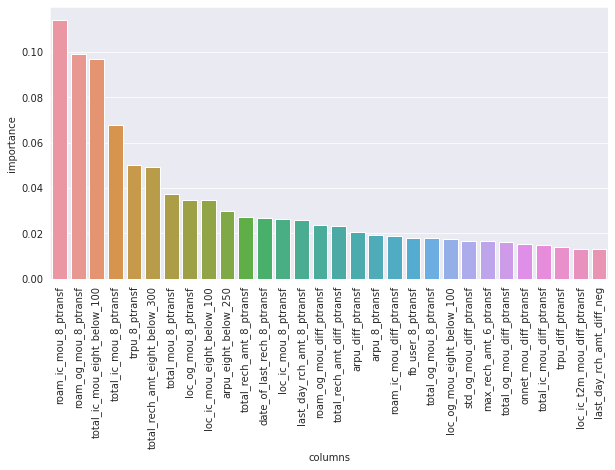

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(data = imp_df, x = 'columns', y = 'importance')
plt.xticks(rotation=90)
plt.show()

### Top 5 important features as as follows

In [ ]:
imp_df.head()

,columns,importance
7,roam_ic_mou_8_ptransf,0.114134
8,roam_og_mou_8_ptransf,0.099269
1,total_ic_mou_eight_below_100,0.096953
12,total_ic_mou_8_ptransf,0.067976
28,trpu_8_ptransf,0.050078


In [ ]:
print(classification_report(y_true=y_train_resamp, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19192
           1       0.99      1.00      0.99     13434

    accuracy                           0.99     32626
   macro avg       0.99      1.00      0.99     32626
weighted avg       0.99      0.99      0.99     32626



In [ ]:
print(accuracy_score(y_true=y_train_resamp, y_pred=y_pred))

0.9947281309385153


In [ ]:
print(precision_score(y_true=y_train_resamp, y_pred=y_pred))

0.9877887303222009


In [ ]:
print(recall_score(y_true=y_train_resamp, y_pred=y_pred))

0.9995533720410897


In [ ]:
y_probs = classifier.predict_proba(X_test_scaled_exp.values)[:,1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished


In [ ]:
classifier.classes_

array([0, 1])

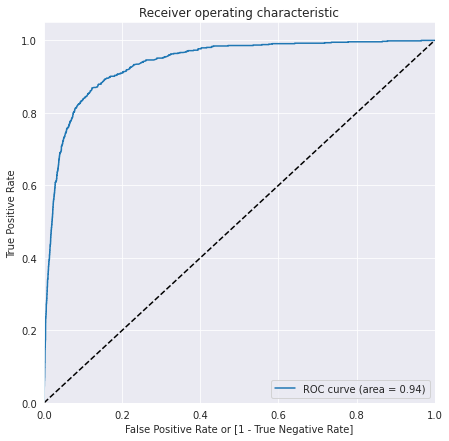

In [ ]:
draw_roc(y_test, y_probs)

In [ ]:
threshold_df = pd.DataFrame({'Churn':y_test, 'probabilities':y_probs})
for i in np.arange(0,1,0.05):
    i = round(i,2)
    threshold_df[i] = threshold_df['probabilities'].apply(lambda x: 1 if x >= i else 0)
threshold_df   

,Churn,probabilities,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
18478,0,0.007269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81980,0,0.000409,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61120,1,0.174685,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30976,0,0.015000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67624,0,0.022327,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51844,0,0.121369,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56960,1,0.338254,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
30332,0,0.240000,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49678,0,0.010222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
accuracy = []
speci = []
sensi = []
cutoffs = []

for i in np.arange(0,1,0.05):
    i = round(i,2)
    cutoffs.append(i)
    cm1 = confusion_matrix(threshold_df.Churn, threshold_df[i] )
    total1=sum(sum(cm1))
    accuracy.append((cm1[0,0]+cm1[1,1])/total1)
    speci.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    sensi.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
cutoff_data = pd.DataFrame({'thresholds':cutoffs, 'accuracy':accuracy, 'specificity': speci, 'sensitivity':sensi})
cutoff_data

,thresholds,accuracy,specificity,sensitivity
0,0.00,0.086406,0.000000,1.000000
1,0.05,0.720235,0.698395,0.951157
2,0.10,0.815971,0.807318,0.907455
3,0.15,0.866171,0.865670,0.871465
4,0.20,0.893159,0.898128,0.840617
5,0.25,0.910484,0.919767,0.812339
6,0.30,0.919924,0.933747,0.773779
7,0.35,0.926699,0.943958,0.744216
8,0.40,0.932141,0.952103,0.721080
9,0.45,0.935140,0.958181,0.691517


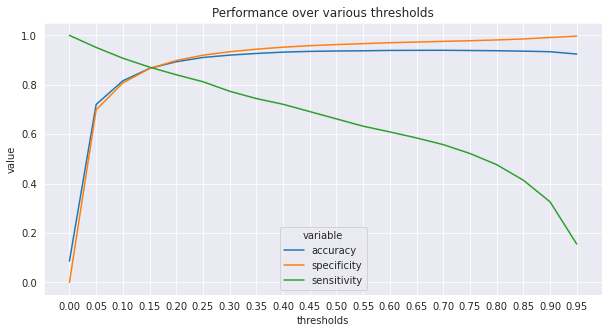

In [ ]:
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='thresholds', y='value', hue='variable', data=pd.melt(cutoff_data, ['thresholds']))
ax.set_title('Performance over various thresholds')
ax.set_xticks(cutoff_data.thresholds)
plt.show()

In [ ]:
p, r, threshold = precision_recall_curve(y_true = threshold_df['Churn'], probas_pred = threshold_df['probabilities'])

In [ ]:
pr_df = pd.DataFrame({'Threshold':threshold, 'Precision':p[:-1], 'Recall':r[:-1]})
pr_df['diff'] = np.abs(pr_df['Recall'] - pr_df['Precision'])
pr_df.sort_values(by = 'diff')

,Threshold,Precision,Recall,diff
6542,0.539360,0.638817,0.638817,0.000000
6541,0.538704,0.637997,0.638817,0.000820
6543,0.540833,0.638353,0.637532,0.000821
6540,0.536304,0.637179,0.638817,0.001638
6544,0.542529,0.637887,0.636247,0.001640
...,...,...,...,...
7314,0.993184,1.000000,0.006427,0.993573
7315,0.993621,1.000000,0.005141,0.994859
7316,0.995000,1.000000,0.003856,0.996144
7317,0.996522,1.000000,0.002571,0.997429


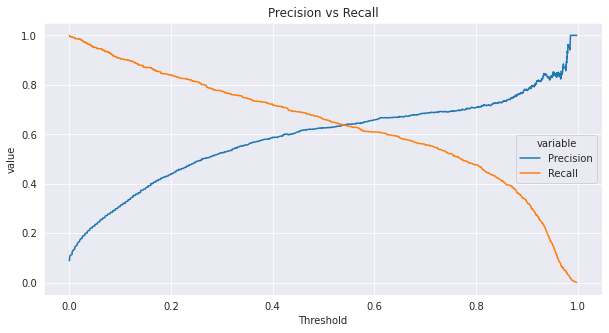

In [ ]:
pr_df_plot = pr_df.drop('diff', axis = 1)
plt.figure(figsize = (10,5))
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data=pd.melt(pr_df_plot, ['Threshold']))
ax.set_title('Precision vs Recall')
plt.show()

### Predictions with optimum threshold

In [ ]:
opt_thresh = pr_df[pr_df['Threshold'] < 0.98].sort_values(by = ['diff', 'Threshold']).iloc[0,0]
opt_thresh

0.5393600444328548

In [ ]:
y_pred = list(map(lambda x: 1 if x >= opt_thresh else 0, y_probs))

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8226
           1       0.64      0.64      0.64       778

    accuracy                           0.94      9004
   macro avg       0.80      0.80      0.80      9004
weighted avg       0.94      0.94      0.94      9004



In [ ]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.9375832963127498


In [ ]:
print(precision_score(y_true=y_test, y_pred=y_pred))

0.6388174807197944


In [ ]:
print(recall_score(y_true=y_test, y_pred=y_pred))

0.6388174807197944


### Strategies to manage churn:
- The company should look out for a fall in following metrics: <b>drop in  incoming calls, drop in total revenue generated per user, total recharge amount being below 300 in eights month, drop in customer using roaming services.</b> Al lthe above factors happening in month 8 seem to be significant in terms of churn.
- For customers showing above patterns, the company can roll out promotional offers for these customers such that customers can be retained.
- If the budget for these offers is high, we can use a lower threshold than optimum to predict churn. This will increase false positives but will reduce false negatives.
- In case of a budget crunch, the company should use the optimum threshold or higher to only filterout the most probable customers about to churn.